# BTC Futures 에 내제되어있는 funding rate term structure 분석

선물 계약은 레버리지가 가능하다. 일정 증거금만 있으면 2배, 3배 많게는 100배 이상 레버리지를 키울 수 있다. 즉 내가 지금 비트코인 10개만큼 사는 포지션을 구축하고 싶은데 레버리지 10배 선물 롱 계약을 체결하면 비트코인 1개로 비트코인 10개만큼 보유하고 있는것과 비슷한 경제적인 효과를 얻을 수 있는 것이다. 투자자가 비트코인 10개를 사려면 비트코인 10개 가치만큼의 현금이 초기에 필요하지만 그만큼의 현금이 없다면 선물이라는 파생상품으로 그 문제를 해결할 수 있는 것이다. 물론 세상엔 공짜 점심은 없기 때문에 이에 합당한 비용을 지불해야 한다. 바로 Funding Fee 또는 현,선물 basis를 통해 그 비용을 지불하게 된다.  \
 일반적인 장내선물 파생상품은 대부분 만기가 정해져 있다. 코인선물시장에서는 만기가 정해진 파생상품도 존재하지만, 거래량과 open interest 가 압도적으로 많은 파생상품은 perpetual 선물이다. BTC perpetual 선물은 만기가 없고 8시간마다(일반적으로) Funding Fee 만큼 정산을 하게 되는데 이걸 1년동안 누적하면 연율화 된 비용이 나오게 된다. 즉 펀딩피를 1년동안 모두 더하면 선물 롱 계약 매수자가 레버리지 1배를 증가시킬 때 마다 드는 비용이 나올 것이다.  \ 
 해외 코인 거래소에서 물론 만기가 있는 선물도 존재한다. 만기가 있는 선물은 가격에 내제되어있는 금리를 구할 수 있고 만기가 길게는 1년까지 존재한다.

 만기가 없는 선물, 만기가 있는 선물의 내제되어있는 금리를 분석하여 선물간 spread 거래를 하거나, 통계적으로 금리가 회귀하는 성질을 이용하여 통계적 차익거래 전략을 생각해 볼 수 있을 것이다. 잔존 만기별 BTC 선물에 내제되어있는 금리를 구조화 시키는 방법을 찾아보고 구현해 보자. \

코인 관련 파생상품은 deribit 거래소가 다양한 파생거래를 지원해 주기 때문에 해당 거래소를 기준으로 분석을 먼저 해보자.(옵션상품 역시 다양한 행사가별, 만기별 상품이 존재)

In [31]:
from crypto import pyderibit, CONFIG
api = pyderibit.Deribit(CONFIG.DERIBIT['MAIN_URL'])

> 선물들에 정보 불러오기.(만기가 끝난 선물들의 경우 api로 리스트를 불러오는 방법은 없기 때문에 선물상장 규칙에 따라 리스트를 불러옴.)

In [32]:
dict_fut = api.get_instruments_all_list('BTC','2018-01-01')

In [33]:
import datetime
currency = 'BTC'
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=3000)
df_all_data = api.get_historical_futures_price(currency+'-'+'PERPETUAL', start_time, end_time)[['ticks','close']]

> 선물들의 가격 불러와서 DataFrame 형태로 정리

In [34]:
import pandas as pd
for symbol, item in dict_fut.items():
    df_k_price = api.get_historical_futures_price(symbol, start_time, end_time)
    df_k_price = df_k_price[((df_k_price.ticks >= item['creation_timestamp']) & (df_k_price.ticks <item['expiration_timestamp']))]
    df_k_price = df_k_price[['ticks','close']]
    df_all_data = pd.merge(df_all_data,df_k_price,on = 'ticks', how='left', suffixes = ('','_'+symbol))

df_all_data['datetime'] = pd.to_datetime(df_all_data['ticks'], unit='ms')
df_all_data.set_index('datetime', inplace=True)

df_all_data.columns = [col.replace('close_', '') for col in df_all_data.columns]
df_all_data = df_all_data.drop(columns=['ticks','close'])
df_all_data = df_all_data.dropna(subset=[currency+'-PERPETUAL'])
df_all_data

,BTC-26JAN18,BTC-23FEB18,BTC-30MAR18,BTC-27APR18,BTC-25MAY18,BTC-29JUN18,BTC-27JUL18,BTC-31AUG18,BTC-28SEP18,BTC-28DEC18,...,BTC-19JUL24,BTC-26JUL24,BTC-16AUG24,BTC-23AUG24,BTC-30AUG24,BTC-27SEP24,BTC-27DEC24,BTC-28MAR25,BTC-27JUN25,BTC-PERPETUAL
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-15 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6345.5,6347.5,6349.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6377.0
2018-08-16 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6452.5,6453.0,6456.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6490.0
2018-08-17 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6434.5,6435.0,6441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6467.0
2018-08-18 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6315.0,6319.5,6320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6351.0
2018-08-19 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6415.0,6413.5,6414.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6454.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-11 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,58710.0,58807.5,58855.0,59310.0,60970.0,62682.5,64275.0,58674.0
2024-08-12 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,59252.5,59335.0,59415.0,59800.0,61545.0,63212.5,64740.0,59256.5
2024-08-13 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60955.0,61015.0,61117.5,61580.0,63260.0,65057.5,66810.0,60943.5


/var/folders/qc/1xrxdszx3m95xzknt3ptpq4c0000gn/T/ipykernel_11270/2723478528.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_mty = pd.Series()


Annual futures 가 처음으로 등장하였을 때:  2021-04-20 08:00:00


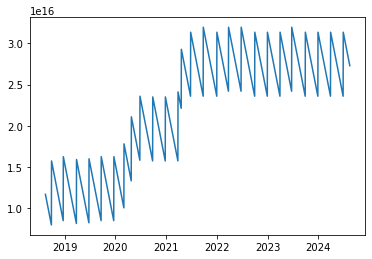

In [159]:
import numpy as np
series_mty = pd.Series()
for idx, row in df_all_data.iterrows():
    
    max_len = max(pd.to_datetime([dict_fut[i]['expiration_timestamp'] for i in row.dropna().drop('BTC-PERPETUAL').index],unit='ms') - idx)
    series_mty[idx] = max_len

plt.plot(series_mty)
start_1y = series_mty[series_mty >= datetime.timedelta(days=350)]
start_1y_index = start_1y.index[0]
print('Annual futures 가 처음으로 등장하였을 때: ',start_1y_index)

In [35]:
from models import termstruc
model = termstruc.InterestTermStructure('BTC', df_all_data, dict_fut)

In [81]:
ls_index = df_all_data.index
filtered_dates = ls_index[ls_index > pd.Timestamp('2020-01-01 08:00:00')]

DatetimeIndex(['2018-08-15 08:00:00', '2018-08-16 08:00:00',
               '2018-08-17 08:00:00', '2018-08-18 08:00:00',
               '2018-08-19 08:00:00', '2018-08-20 08:00:00',
               '2018-08-21 08:00:00', '2018-08-22 08:00:00',
               '2018-08-23 08:00:00', '2018-08-24 08:00:00',
               ...
               '2024-08-06 08:00:00', '2024-08-07 08:00:00',
               '2024-08-08 08:00:00', '2024-08-09 08:00:00',
               '2024-08-10 08:00:00', '2024-08-11 08:00:00',
               '2024-08-12 08:00:00', '2024-08-13 08:00:00',
               '2024-08-14 08:00:00', '2024-08-15 08:00:00'],
              dtype='datetime64[ns]', name='datetime', length=2193, freq=None)

> 30일, 60일, 120일, 180일, 240일, 300일, 360일 을 기준으로 펀딩피를 interpolation 하기.

In [167]:
ls = {}
term = [30, 60, 120, 180, 240, 300, 360]
for i in df_all_data.loc[start_1y_index:].index:
    ls_term = []
    for j in term:
        ls_term.append(model.get_zrate(i, i + datetime.timedelta(days = j)))
    ls[i] = ls_term

In [168]:
df_termstructure = pd.DataFrame(ls)
df_termstructure = df_termstructure.transpose()
df_termstructure.columns = term

> Term Structure의 모습 시각화

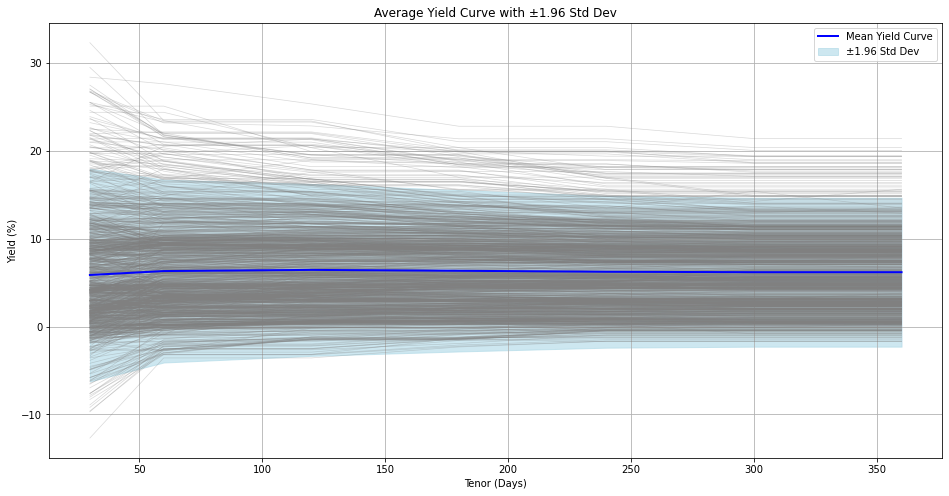

In [208]:
import matplotlib.pyplot as plt

df_data = df_termstructure * 100

mean_yield = df_data.mean(axis=0)
std_yield = df_data.std(axis=0)

std_multiple = 1.96 # 95%

plt.figure(figsize=(16, 8))

for date in df_data.index:
    plt.plot(df_data.loc[date], alpha=0.3, color = 'gray', linewidth=0.7)

plt.plot(mean_yield, color='blue', linewidth=2, label='Mean Yield Curve')
plt.fill_between(term, mean_yield - std_yield * std_multiple, mean_yield + std_yield * std_multiple, color='lightblue', alpha=0.6, label=f'±{std_multiple} Std Dev')

plt.title(f'Average Yield Curve with ±{std_multiple} Std Dev')
plt.xlabel('Tenor (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

> 각 테너별 yield의 baxplot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


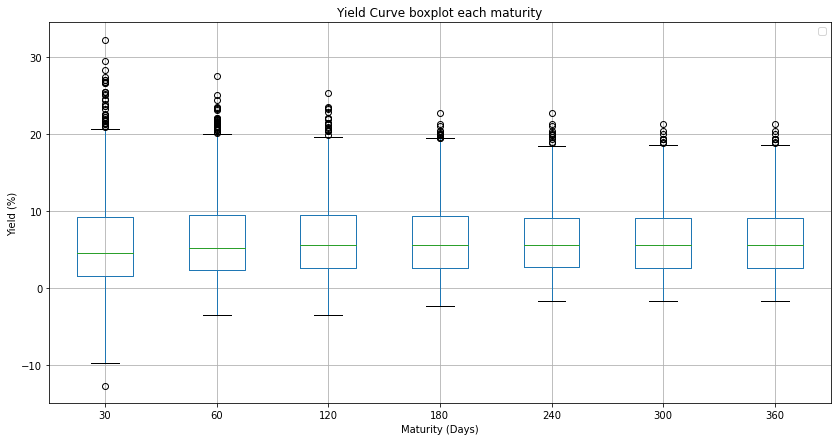

In [181]:
plt.figure(figsize=(14, 7))
df_data.boxplot()

plt.title(f'Yield Curve boxplot each maturity')
plt.xlabel('Maturity (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

> 각 테너별 yield 의 time series

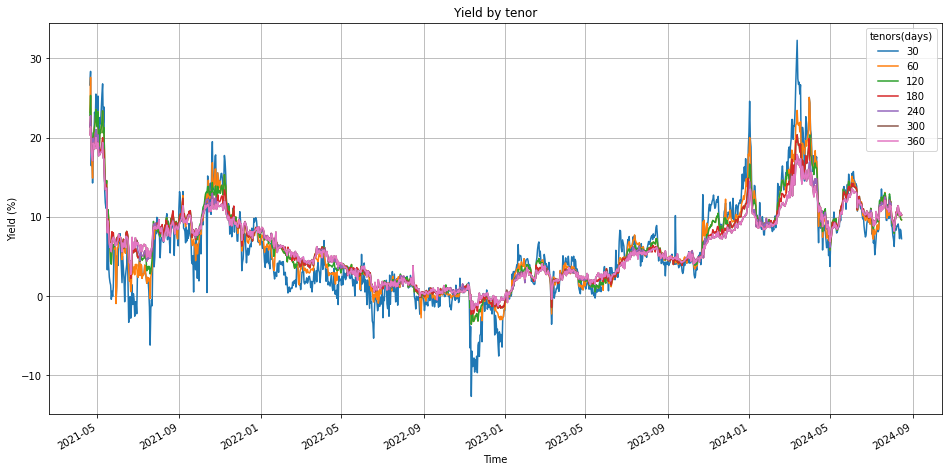

In [192]:
df_data.plot(figsize=(16,8))
plt.title(f'Yield by tenor')
plt.xlabel('Time')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend(title = 'tenors(days)')
plt.show()

> 120일 만기 선물과 240일 만기 선물 비교하기

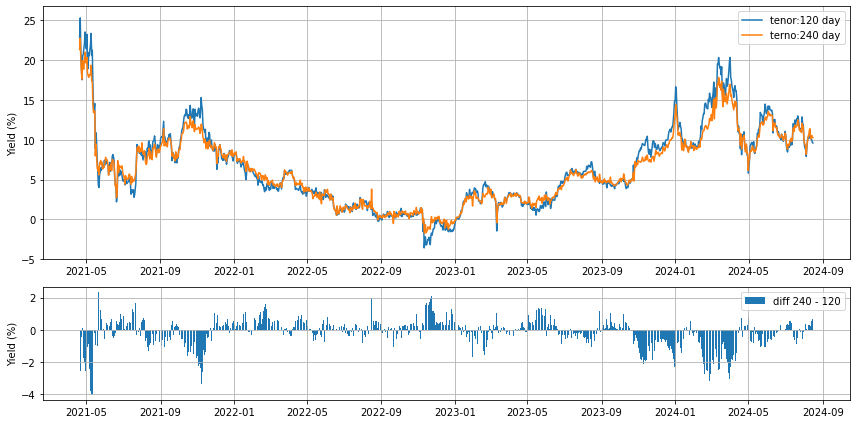

In [212]:
from matplotlib.gridspec import GridSpec

tenor1 = 120
tenor2 = 240
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax1.plot(df_data[tenor1], label=f'tenor:{tenor1} day')
ax1.plot(df_data[tenor2], label=f'terno:{tenor2} day')
plt.grid(True)
plt.ylabel('Yield (%)')
ax1.legend()

diff = df_data[tenor2]-df_data[tenor1]
ax2 = fig.add_subplot(gs[2, 0])
ax2.bar(diff.index,diff.values, label=f'diff {tenor2} - {tenor1}')
plt.grid(True)
plt.ylabel('Yield (%)')
ax2.legend()

plt.tight_layout()
plt.show()

만기가 120일, 240일 인 선물의 금리 차이를 보게 되면 Oscillate 한 움직임을 볼 수 있다. 240일과 120일 금리차가 + 였다가 - 였다가를 반복하는 모습이다. +로 일정 수준 이상으로 벌어지면 만기가 240일인 선물 short, 120일인 선물 long 포지션을 취하고 금리차가 다시 0에 수렴하면 포지션을 청산하는 방식으로 거래 기회를 포착할 수 있을 것이다.  
> 위에 전략을 전략 1 이라고 하자. 

전략 1 포지션을 만들때 고려해야 되는 민감도들이 있다. 여기서 민감도는 특정 변수가 움직일 때 포지션의 변화를 나타낸다. 선물가격은 F = s x exp(r * t) 로 표현한다면 여기서 선물 가격의 영향을 주는 요소는 3가지가 있게 된다. 비트코인 가격(s) 1% 올랐을때 포지션의 가치변화를 delta라 하고, 금리(r) 1bp 올랐을 때 포지션 가치변화를 rho 라고 하고 시간(t) 가 하루 경과 했을때 가치변화를 theta 라고 하자. 그러면 delta 는 exp(r*t) 가 되고 r과 t 에 따라 다르겠지만 거의 1에 근접한 값이 된다. 즉 만기가 다른 선물의 delta는 거의 1에 근접하다. 그런데 rho 는.. t * F 가 되기 때문에 만기가 두배가 되면 rho 도 두배가 된다. 만약 120일 선물 1계약 long 240일 만기 선물 1계약 short 을 하게 되면 delta는 어느정도 중립이 되지만 rho는 2배가 차이가 된다. 그렇게 되면 이자율 절대 level에 따라 손익이 바뀌게 된다.(240일 만기 선물과 120 만기 선물의 금리차이를 이용하여 트레이딩 하고 싶다면 이러한 효과를 없애야 한다) 마지막으로 theta는 r * F 가 되고 이는 r에 따라서 결정이 될 것이다. 
* 전략 1 포지션

case 1. 240일 만기 선물 내제금리가 높고(선물가격이 상대적으로 높다) 120일 만기 선물 내제금리가 낮을 때(선물가격이 상대적으로 낮다)  \
 -> 240 선물 short 1계약, 120 선물 long 2계약, perpetual 선물 short 1계약 (delta: 0, rho: 0, theta: 240선물 내제금리 - 2 * 120선물 내제금리 + funding fee)

case 2. 240일 만기 선물 내제금리가 낮고(선물가격이 상대적으로 낮다) 120일 만기 선물 내제금리가 높을 때(선물가격이 상대적으로 높다)  \
 -> 240 선물 long 1계약, 120 선물 short 2계약, perpetual 선물 long 1계약 (delta: 0, rho: 0, theta: -240선물 내제금리 + 2 * 120선물 내제금리 - funding fee)

(단, 딱 만기가 240, 120일 인 선물은 존재하지 않기 때문에 근처 만기 선물 조합을 이용해야 함.)

* 레버리지

위에 240일 선물과 120 선물 가격차이는 최대 4% 까지 벌어졌으나 기회가 보이는 정도는 선물내제금리 차이가 1%~2% 정도이다. 만약 2%를 먹는다고 했을때 수익률로 환산하면 120일 선물 델타를 고려했을때 0.33% ~ 0.66% 정도가 된다. 생각보다 작은 수익률이지만.. deribit은 포트폴리오로 margin을 관리할 수 있기 때문에 delta중립으로 맞추면 25배 까지 레버리지를 키울 수 있다.  \
만약 금리 차이가 2%가 일 때 포지션을 취해서 0% 일 때 포지션을 청산한다면 대략적인 손익은 delta(120일 선물: 0.33) * 2%(금리차이 변동) * 25(최대 레버리지) = 16.5% 이 된다.

## 정리

위에 결과는 기초적인 모델링과 기초분석 정도이고 실제 수익이 날지, 수익성이 어느정도인지 백테스트는 더 많은 요소들을 고려해야 될 것이다. 큰 방향을 베팅하는 것이 아닌, 중립포지션을 취하여 가격 스프레드 만큼 수익 기회를 포착하는 전략은 거래량 대비 수익의 크기는 낮을 수 있다.(반대로 손실에 대한 리스크는 더 낮은 전략) 따라서 거래 수수료 비용이 매우 큰 변수 중 하나 일 것이다. 또한 일반적으로 perpetual 선물에 비해 만기가 정해져 있는 선물은 유동성이 상대적으로 적기 때문에 거래규모가 크다면 거래를 할 수록 가격이 불리한 방향으로 밀리게 되는 슬리피지 효과를 고려해야 될 것이다.